# Machine Learning for Time Series - Project 4.5 - K-SVD

**Authors:**
* Grégoire GISSOT
* Tom LABIAUSSE

This notebook is the summary of the experiments made by Grégoire Gissot and Tom Labiausse for the course Machine Learning for Time Series and their mini-project based on the article : 
**[K-SVD: An Algorithm for Designing Overcomplete Dictionaries for Sparse Representation](https://legacy.sites.fas.harvard.edu/~cs278/papers/ksvd.pdf)** written by ***Michal Aharon, Michael Elad*** and ***Alfred Bruckstein***

**Summary of the notebook:**

1. Implementation of the K-SVD method (only using numpy)
2. Atoms retrieval with synthetic data
3. Reconstruction of signals with missing values
4. Signal classification experiments on the ArticularyWordRecognition (AWR) Dataset

The second and third parts are reproduction and improvements on the article's experiments and the last one is our new experiment based on a real dataset.

**Github repository link:** [K-SVD project](https://github.com/t0m1ab/K-SVD)

## 0 - Libraries and utility functions

In [1]:
import os
from pathlib import Path
from time import time
from tqdm import tqdm
from multiprocessing.pool import Pool
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.linear_model import orthogonal_mp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix   
from sklearn.datasets import fetch_olivetti_faces
import seaborn as sns 
from scipy.io import arff
import pandas as pd
from dtw import dtw

### Define utility functions for the whole notebook

In [4]:
def split_path_and_filename(file_path: str) -> (str, str):
    """ Split a file path into its directory and filename. """
    path = Path(file_path)
    return path.parent, path.name


def convert_255_to_unit_range(image: np.ndarray) -> np.ndarray:
    """
    Convert image with values in range [0,255] to image with values in range [-1,1].
    """
    return np.array(np.clip(image, a_min=0, a_max=255), dtype=np.float32) / 255


def convert_unit_range_to_255(image: np.ndarray) -> np.ndarray:
    """
    Convert image with values in range [-1,1] to image with values in range [0,255].
    """
    return np.array(255 * np.clip(image, a_min=0.0, a_max=1.0), dtype=np.uint8)


def plot_results_synthetic_exp(
        data_dir: str = None, 
        n_runs: int = 50,
        noise_levels: list = None,
        success_threshold: float = 0.01, 
        plot_groups: bool = False, 
        group_size: int = 10
    ) -> None:
    """
    DESCRIPTION:
        Plot the results of the synthetic experiment for different noise levels.
    ARGS:
        - data_dir: path to the folder containing the results
        - n_runs: number of runs for each noise level
        - noise_levels: list of noise levels to plot (None means default noise levels apply: [None, 10, 20, 30])
        - success_threshold: threshold for the success score
        - plot_groups: if True, plot the mean success score for groups of 'group_size' runs
        - group_size: number of runs to group together if plot_groups is True
    """
    
    # noise level labels traduction
    if noise_levels is None:
        snr_levels = {"no_noise": 0, "10dB": 10, "20dB": 20, "30dB": 30}
    else:
        snr_levels = {}
        for level in noise_levels:
            if level is None:
                snr_levels["no_noise"] = 0
            else:
                snr_levels[f"{str(level)}dB"] = level

    fig, ax = plt.subplots(figsize=(10, 5))

    for snr_label, snr_level in snr_levels.items():
        file_path = os.path.join(data_dir, f"success_scores_{snr_label}.npy")
        if not os.path.isfile(file_path):
            print(f"File '{file_path}' was not found in '{data_dir}'")
            continue
        scores = np.load(file_path)
        n_scores = scores.shape[0]

        if plot_groups and n_scores % group_size == 0:
            sorted_scores = np.sort(scores)
            group_mean_scores = np.mean(sorted_scores.reshape((-1, group_size)), axis=1)
            absc = snr_level * np.ones(group_mean_scores.shape[0])
            ax.scatter(absc, group_mean_scores, marker="s", color="red")
        else:
            absc = snr_level * np.ones(scores.shape[0])
            ax.scatter(absc, scores, marker="o", color="black")
    
    ax.set_title(f"Success scores over {n_runs} runs for the synthetic experiment", size=16)
    ax.set_xticks(sorted(snr_levels.values()), ["No noise", "10dB", "20dB", "30dB"])
    ax.set_yticks([0, 10, 30, 40, 50])
    ax.set_xlabel("SNR (dB)")
    ax.set_ylabel(f"success score (threshold={success_threshold})")
    ax.grid(True)
    ax.set_axisbelow(True) # put grid behind the plot
    fig.savefig(os.path.join(data_dir, "success_scores.png"), dpi=300)
    print(f"Figure 'success_scores.png' saved in '{data_dir}'")


def is_power_of_two(n: int) -> bool:
    """
    Check if n is a power of two.
    """
    if (n == 1) or (n == 0):
        return True
    elif n % 2 == 1:
        return False
    else:
        return is_power_of_two(n // 2)


def create_haar_row(n: int) -> np.ndarray:
    """
    Create a pure vertical haar frequencies as patches of size n x n.
    """

    if not is_power_of_two(n):
        raise ValueError("n must be a power of two.")
    
    log_n = int(np.log2(n))
    n_patches = 1 + (n//2) + n*(log_n-1) if log_n > 1 else 2
    haar_row = np.zeros((n, n*n_patches)) # n components for each frequency + continuous component

    # continuous component
    haar_row[:,0:n] = -np.ones((n, n), dtype=np.float32)

    # create patches for each frequency (n patches by frequency except fondamental with n//2 patches)
    half_length = n
    for freq in range(log_n):
        half_length = half_length//2
        positive_positions = np.arange(0, half_length)
        negative_positions = np.arange(half_length, 2*half_length)
        freq_shift = n if freq == 0 else n + n*(n//2) + n*n*(freq-1) # patch_size * number of patches before first patch with frequency freq
        for shift in range(n if freq > 0 else n // 2):
            # absolute positions in haar_row
            pos_col_index = freq_shift + n*shift + positive_positions
            neg_col_index = freq_shift + n*shift + negative_positions
            # define the corresponding patch
            haar_row[:,pos_col_index] = 1.0
            haar_row[:,neg_col_index] = -1.0
            # shift signal one pixel to the right for next patch
            positive_positions = (positive_positions + 1) % n
            negative_positions = (negative_positions + 1) % n
    
    return haar_row

        
def create_haar_dict(
        patch_size: int, 
        K:int, 
        normalize_atoms: bool = False, 
        transpose_dict: bool = False
    ) -> np.ndarray:
    """
    DESCRIPTION:
        Create an overcomplete haar dictionary containing K patches of size patch_size x patch_size.
        Use the trick of the tensor product between pure vertical/horizontal to create the dictionary then converts back to vectors.
        The resulting atoms in the dictionary have values in [-1,1] and are not normalized by default.
    ARGS:
        - patch_size: size of the patches
        - K: number of atoms in the dictionary
        - normalize_atoms: if True, each atom will have a unit norm
        - transpose_dict: if True, return the transposed order of the dictionary 
    """

    n_patches_edge = np.sqrt(K).astype(int)
    if not n_patches_edge**2 == K:
        raise ValueError("K must be a perfect square.")

    # create first row and first column
    vert_freq = create_haar_row(n=patch_size)
    horz_freq = vert_freq.T

    # create the complete haar dictionary with product of vertical and horizontal frequencies
    haar_collection = np.zeros((vert_freq.shape[1], horz_freq.shape[0]))
    haar_collection[:patch_size, :] = vert_freq
    haar_collection[:, :patch_size] = horz_freq
    haar_collection[patch_size:, patch_size:] = horz_freq[patch_size:, :] @ vert_freq[:, patch_size:] / patch_size

    # convert each patch to a n*n vector
    if n_patches_edge != haar_collection.shape[0] // patch_size:
        raise ValueError("Uncomplete implementation for haar dictionary. Please set K=441.")
    n_patches = n_patches_edge ** 2
    haar_dict = np.zeros((patch_size**2, n_patches))
    for row in range(n_patches_edge):
        for col in range(n_patches_edge):
            up = row * patch_size
            left = col * patch_size
            if transpose_dict:
                left, up = up, left
            vector_atom = haar_collection[up:up+patch_size, left:left+patch_size].reshape(-1)
            haar_dict[:,n_patches_edge*row+col] = vector_atom

    haar_dict[:,0] = np.ones((patch_size**2,)) # set the first atom to the constant vector 1

    if normalize_atoms: # force each atom to have a unit norm
        haar_dict = haar_dict / np.linalg.norm(haar_dict, axis=0)

    return haar_dict


def create_dct_row(n: int, freq_range: int) -> np.ndarray:
    """
    Create 1D cosine signals for each freq in [0,freq_range[ using DCT-II: https://en.wikipedia.org/wiki/Discrete_cosine_transform
    Order them into a (freq_range, n) matrix and reshape it into a (1, freq_range*n) row vector.
    """
    table = np.array([[np.cos((0.5 + i) * k * np.pi / freq_range) for i in range(n)] for k in range(freq_range)])
    return table.reshape((1,-1))


def create_dct_dict(
        patch_size: int, 
        K:int, 
        normalize_atoms: bool = False,
        transpose_dict: bool = False
    ) -> np.ndarray:
    """
    DESCRIPTION:
        Create an overcomplete dct dictionary containing K patches of size patch_size x patch_size.
        Use the trick of the tensor product between pure vertical/horizontal to create the dictionary then converts back to vectors.
        The resulting atoms in the dictionary have values in [-1,1] and are not normalized by default.
    ARGS:
        - patch_size: size of the patches
        - K: number of atoms in the dictionary
        - normalize_atoms: if True, each atom will have a unit norm
        - transpose_dict: if True, return the transposed order of the dictionary 
    """

    n_patches_edge = np.sqrt(K).astype(int)
    if not n_patches_edge**2 == K:
        raise ValueError("K must be a perfect square.")

    # create dct row and first column
    dct_row = create_dct_row(n=patch_size, freq_range=n_patches_edge)

    # create the overcomplete dct dictionary with product of vertical and horizontal frequencies
    dct_collection = dct_row.T @ dct_row

    # convert each patch to a n*n vector
    dct_dict = np.zeros((patch_size**2, K))
    for row in range(n_patches_edge):
        for col in range(n_patches_edge):
            up = row * patch_size
            left = col * patch_size
            if transpose_dict:
                left, up = up, left
            vector_atom = dct_collection[up:up+patch_size, left:left+patch_size].reshape(-1)
            dct_dict[:,n_patches_edge*row+col] = vector_atom

    if normalize_atoms: # force each atom to have a unit norm
        dct_dict = dct_dict / np.linalg.norm(dct_dict, axis=0)

    return dct_dict


def plot_residuals(file_path: str, dict_name: str = None) -> None:
    """
    DESCRIPTION:
        Create the plot of residuals recorded during a KSVD training.
    ARGS:
        - file_path: path to the .npy file containing the residuals
        - dict_name: name of the trained dictionary
    """

    if not os.path.isfile(file_path):
        raise ValueError(f"File not found: {file_path}")

    # infer dict_name if not provided
    file_dir, filename = split_path_and_filename(file_path)
    if dict_name is None:
        dict_name = filename.split(".")[0]
        if dict_name.endswith("_res"):
            dict_name = dict_name[:-4]

    residuals = np.load(file_path)
    
    # plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(residuals, linestyle="-")
    ax.set_title(f"Total residual value during {dict_name.upper()} training", size=16)
    ax.set_xlabel("iteration")
    ax.set_ylabel("residual")

    # save
    fig.savefig(os.path.join(file_dir, f"{dict_name}_residuals.png"), dpi=300)

## 1 - Implementation of the K-SVD method ###

### 1.1 - Pursuits methods

In [2]:
class Pursuit():
    """ 
    Class of pursuit algorithms solving the following category of problems: 
        $$ \min_{x} ||y - Ax||_2^2 $$ such that $||x||_0 \leq T_0$
    - $A$ is a dictionary with atoms as columns
    - $y$ is a signal to decompose as a column vector
    - $T_0$ is the sparsity constraint (max number of atoms from the dictionary to use for reconstruction)

    $y$ can be a matrix containing multiple signals as its columns and $x$ the corresponding matrix giving the sparse representation.
    """
    def __init__(self, dict: np.ndarray, sparsity: int = None, verbose: bool = False) -> None:
        self.dict = dict
        self.sparsity = sparsity
        self.is_fit = False
        self.verbose = verbose
    
    def fit(self, y: np.ndarray):
        """
        Solve the pursuit problem for the signal $y$, the dictionary $self.dict$ and the sparsity constraint $self.sparsity$.
        """
        raise NotImplementedError("This method should be implemented in a child class.")


class OrthogonalMatchingPursuit(Pursuit):

    def __init__(self, dict: np.ndarray, sparsity: int = None, verbose: bool = False) -> None:
        super().__init__(dict, sparsity, verbose)
        self.signal = None
        self.support = None
        self.coeffs = None
        self.selection_order = None
        self.res_norms = None
        self.reconstructions = None

    def fit(self, y: np.ndarray, force: bool = False, return_coeffs: bool = False, **kwargs):

        n = self.dict.shape[0] # n_features
        K = self.dict.shape[1] # n_atoms
        N = y.shape[1] # n_signals

        if y.shape[0] != n:
            raise ValueError(f"y should have {n} rows (like self.dict which has the shape {self.dict.shape}), but has {y.shape[0]} rows instead.")
        
        if self.is_fit and not force:
            raise ValueError("OMP.fit() has already been run. If you run it again, you will loose the previous results. Set force=True to run it anyway.")

        self.y = y
        residual = y.copy()
        self.coeffs = np.zeros((K, N), dtype=float)
        self.support = np.zeros((K, N), dtype=bool)
        self.selection_order = np.zeros((self.sparsity, N), dtype=int)
        self.res_norms = np.zeros((self.sparsity+1, N), dtype=float)
        self.res_norms[0] = np.linalg.norm(residual, axis=0)
        self.reconstructions = np.zeros((n, y.shape[1], self.sparsity), dtype=float)
        self.is_fit = False
        self.runtime = time()
        
        for iteration in tqdm(range(self.sparsity), desc="OMP iterations") if self.verbose else range(self.sparsity):

            # find best atom
            projections = self.dict.T @ residual # projections[i,j] is the projection of the j-th signal on the i-th atom
            self.selection_order[iteration] = np.argmax(np.abs(projections), axis=0) # argmax on each column
            self.support[self.selection_order[iteration], np.arange(N)] = True

            # coefficients update with orthogonal projection
            for sample_idx in range(N):
                indexes = np.where(self.support[:, sample_idx].reshape(-1))[0] # indexes as a row
                vect = self.dict[:, indexes]
                self.coeffs[indexes, sample_idx] = np.linalg.pinv(vect.T @ vect) @ vect.T @ y[:, sample_idx]

            # residual update
            reconstruction = self.dict @ self.coeffs
            self.reconstructions[:, :, iteration] = reconstruction
            residual = y - reconstruction
            self.res_norms[iteration + 1] = np.linalg.norm(residual, axis=0)
        
        self.is_fit = True
        self.runtime = time() - self.runtime

        if return_coeffs:
            return self.coeffs

    def plot_residual_norms(self, plot: bool = True, save: bool = False, save_dir: str = None):
        """ Plot the evolution of each residual norm during the OMP iterations """

        if not self.is_fit:
            raise ValueError("The OMP algorithm has not been run yet. Please run OMP.fit() first.")
        
        fig, ax = plt.subplots()
        for res_idx in range(self.res_norms.shape[1]):
            res_values = self.res_norms[:, res_idx] / self.res_norms[0, res_idx]
            ax.plot(res_values, marker="o")
        mean_res_values = np.mean(self.res_norms, axis=1) / np.mean(self.res_norms[0])
        ax.plot(mean_res_values, linestyle="--", color="black", label="mean")
        ax.set_xlabel("step")
        ax.set_ylabel("Ratio residual_norm / signal_norm")
        ax.title.set_text("Residuals norm evolution during OMP iterations")

        if plot:
            plt.show()
        if save:
            if save_dir is None:
                save_dir = "default_plots/"
            Path(save_dir).mkdir(parents=True, exist_ok=True)
            fig.savefig(os.path.join(save_dir, "residual_norms.png"))


class SklearnOrthogonalMatchingPursuit(Pursuit):

    def __init__(self, dict: np.ndarray, sparsity: int = None, verbose: bool = False) -> None:
        super().__init__(dict, sparsity, verbose)
    
    def fit(self, y: np.ndarray, precompute: bool = False, force: bool = False, return_coeffs: bool = False, **kwargs):
        n = self.dict.shape[0]

        if y.shape[0] != n:
            raise ValueError(f"y should have {n} rows (like self.dict which has the shape {self.dict.shape}), but has {y.shape[0]} rows instead.")
        
        if self.is_fit and not force:
            raise ValueError("OMP.fit() has already been run. If you run it again, you will loose the previous results. Set force=True to run it anyway.")

        self.is_fit = False
        self.runtime = time()
        result = orthogonal_mp(X=self.dict, y=y, n_nonzero_coefs=self.sparsity, precompute=precompute)
        self.is_fit = True
        self.runtime = time() - self.runtime

        if return_coeffs:
            if y.shape[1] == 1:
                result = result.reshape(-1,1)
            return result


### 1.2 - K-SVD

In [3]:
class KSVD:
    """ 
    K-SVD algorithm to learn a dictionary from a set of signals as well as the sparse representation of these signals using the dictionary .
    """
    def __init__(
            self, 
            n_atoms: int, 
            sparsity: int, 
            pursuit_method: Pursuit, 
            use_dc_atom: bool = False, 
            init_dict: np.ndarray = None,
            dict_name: str = None,
            save_dir: str = None,
            verbose: bool = False,
        ) -> None:
        """
        ARGS:
            - n_atoms: number of atoms in the dictionary
            - sparsity: max number of atoms used to reconstruct each signal
            - pursuit_method: pursuit method used to solve the sparse coding problem
            - use_dc_atom: if True, the first atom of the dictionary is the DC atom and is never updated
            - init_dict: if not None, the KSVD algorithm will start from this dictionary
            - dict_name: name given to the learned dictionary
            - save_dir: directory where to save the learned dictionary
        """

        self.K = n_atoms
        self.sparsity = sparsity
        self.pursuit_method = pursuit_method
        self.dict = init_dict
        self.dc_atom = use_dc_atom
        self.dict_name = "ksvd_dict" if dict_name is None else dict_name
        self.save_dir = "outputs/" if save_dir is None else save_dir
        self.coeffs = None
        self.iteration = None
        self.residual_history = None
        self.verbose = verbose
        self.is_fit = False
    
    def fit(
            self, 
            y: np.ndarray, 
            max_iter: int = None, 
            tol: float = None, 
            save_chekpoints: bool = False,
            checkpoint_steps: int = 10,
            return_reconstruction: bool = False,
        ):
        """
        DESCRIPTION:
            Learn a dictionary from the signals $y$ using the KSVD algorithm.
        ARGS:
            - y: matrix containing the signals (as column vectors) to learn the dictionary from
            - max_iter: max number of iterations in the main loop of KSVD
            - tol: tolerance value for the stopping criterion
            - save_chekpoints: if True, save checkpoints of the dictionary during training
            - checkpoint_steps: number of iterations of the main loop of KSVD between each checkpoint save
            - return_reconstruction: if True, return the reconstruction of the signals using the learned dictionary
        """

        if self.is_fit:
            raise ValueError("KSVD.fit() has already been run. If you run it again, you will loose the previous results.")
        
        if (max_iter is None and tol is None) or (max_iter is not None and tol is not None):
            raise ValueError("Either max_iter or tol must be specified as a stopping rule and you can't specify both.")
        
        n, N = y.shape # n_features, n_signals

        # init dictionary from scratch if no dict checkpoint is provided
        if self.dict is None:
            self.dict = np.random.randn(n, self.K)
            self.dict /= np.linalg.norm(self.dict, axis=0)
        elif self.dict.shape != (n, self.K):
            raise ValueError(f"The shape of the dictionary was expected to be ({n}, {self.K}) but is {self.dict.shape} instead.")

        if self.dc_atom: # first atom is the DC atom and other atoms are zero mean
            self.dict[:,0] = np.ones(n, dtype=float) / np.sqrt(n)
            self.dict[:,1:] -= np.mean(self.dict[:,1:], axis=0)

        if save_chekpoints: # create checkpoints directory if it does not exist
            checkpoint_dir = os.path.join(self.save_dir, self.dict_name)
            Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

        self.residual_history = []
        stopping_criterion = False
        self.iteration = 0
        while not stopping_criterion:

            # sparse coding stage
            pursuit_algo = self.pursuit_method(dict=self.dict, sparsity=self.sparsity, verbose=False)
            self.coeffs = pursuit_algo.fit(y=y, precompute=False, return_coeffs=True)

            # codebook update stage
            for k in range(int(self.dc_atom), self.K):
                
                selected_indexes = [i for i in range(self.K)]
                selected_indexes.pop(k)
                selected_indexes = np.array(selected_indexes)
                E_k = y - self.dict[:,selected_indexes] @ self.coeffs[selected_indexes,:]

                xk_T_nonzero_indexes = np.where(self.coeffs[k])[0]
                
                if len(xk_T_nonzero_indexes) > 0: # atom k should be used in at least one signal to be updated
                    omega_k = np.zeros((N, xk_T_nonzero_indexes.shape[0]))
                    omega_k[xk_T_nonzero_indexes, np.arange(xk_T_nonzero_indexes.shape[0])] = 1

                    U, delta, Vh = np.linalg.svd(E_k @ omega_k, full_matrices=True)

                    self.dict[:,k] = U[:,0]
                    self.coeffs[k,xk_T_nonzero_indexes] = delta[0] * Vh[0,:]
                else:
                    print(f"Atom {k} was not used in any signal therefore it was not updated during this iteration.")

            residual = np.linalg.norm(y - self.dict @ self.coeffs)
            self.residual_history.append(residual)
            stopping_criterion = self.check_stopping_rule(residual, max_iter, tol)

            if self.verbose:
                total_iter = f"/{max_iter}" if max_iter is not None else ""
                print(f"# Iter {self.iteration}{total_iter} | loss = {residual}")
            
            if save_chekpoints and (self.iteration%checkpoint_steps == 0):
                checkpoint_name = f"{self.dict_name}_iter={self.iteration}.npy"
                res_values_name = f"{self.dict_name}_iter={self.iteration}_res.npy"
                np.save(os.path.join(checkpoint_dir, checkpoint_name), self.dict)
                np.save(os.path.join(checkpoint_dir, res_values_name), np.array(self.residual_history))
                print(f"Checkpoint [iter={self.iteration}] saved in {os.path.join(checkpoint_dir, checkpoint_name)}")

        if return_reconstruction:
            return self.dict @ self.coeffs
    
    def check_stopping_rule(self, residual: float, max_iter: int, tol: float):
        """
        DESCRIPTION:
            Return True if the stopping rule is satisfied, False otherwise.
            If residual is None then the stopping rule is based on the number of iterations.
            If tol is None then the stopping rule is based on the residual value.
        ARGS:
            - residual: current residual value
            - max_iter: max number of iterations allowed for the main loop of KSVD
            - tol: tolerance value for the stopping criterion
        """
        self.iteration += 1
        if max_iter is not None:
            return self.iteration >= max_iter
        elif tol is not None:
            return residual < tol
        raise ValueError("Either max_iter or tol must be specified as a stopping rule.")

## 2 - Atoms retrieval with synthetic data

### 2.1 - Synthetic data generator

In [5]:
class SyntheticDataGenerator:
    
    def __init__(self, n_features: int) -> None:
        """
        ARGS:
            - n_features: dimension of the signals
        """
        self.n_features = n_features
        self.dict = None
        self.coeffs = None
        self.signals = None
    
    def create_synthetic_dictionary(self, n_atoms: int, normalize_columns: bool = False, return_dict: bool = False):
        """ 
        DESCRIPTION:
            Create a synthetic dictionary of $n_atoms$ atoms of dimension $n_features$.
            Each atom is a random vector of dimension $n_features$.
        ARGS:
            - n_atoms: number of atoms in the dictionary
            - normalize_columns: if True, normalize the columns of the dictionary
            - return_dict: if True, return the dictionary
        """

        self.dict = np.random.uniform(low=-1.0, high=1.0, size=(self.n_features, n_atoms))
        if normalize_columns:
            self.dict /= np.linalg.norm(self.dict, axis=0)
        if return_dict:
            return self.dict

    def create_synthetic_signals(self, n_signals: int, sparsity: int, noise_std: float = 0, return_signals: bool = False):
        """ 
        DESCRIPTION:
            Create a synthetic set of $n_signals$ signals of dimension $n_features$.
            Each signal is a sparse linear combination of $sparsity$ atoms from $dict$.
        ARGS:
            - n_signals: number of signals to create
            - sparsity: number of atoms used to construct each signal
            - noise_std: standard deviation of the noise added to the signals
            - return_signals: if True, return the signals
        """

        if self.dict is None:
            raise ValueError("You must create a dictionary before creating signals.")

        n_atoms = self.dict.shape[1]
        self.coeffs = np.zeros((n_atoms, n_signals))
        for idx in range(n_signals):
            self.coeffs[np.random.choice(n_atoms, size=sparsity, replace=False), idx] = 1
        self.signals = self.dict @ self.coeffs

        if noise_std > 0:
            # print(f"Noise std added to the signals = {noise_std}")
            self.signals += np.random.normal(scale=noise_std, size=(self.n_features, n_signals))

        if return_signals:
            return self.signals
    
    def sucess_score(self, designed_dict: np.ndarray, threshold: float = 0.01):
        """ 
        DESCRIPTION:
            Compute the success score (see the paper for details) of $designed_dictionary$ with respect to the dictionary $self.dict$.
        ARGS:
            - designed_dict: the dictionary to test
            - threshold: the threshold to use to determine if two atoms are matching
        """

        if self.dict is None:
            raise ValueError("You must create a dictionary before computing the success score.")

        if self.dict.shape != designed_dict.shape:
            raise ValueError("The shape of the designed dictionary must be the same as the shape of the dictionary created by the class.")

        n_atoms = self.dict.shape[1]
        atoms_matching = -1 * np.ones(n_atoms)

        # iter over each learned atom to find a matching atom in the designed dictionary
        for col_idx in range(n_atoms):
            distance = np.ones(n_atoms) - np.abs(self.dict[:,col_idx].T @ designed_dict) # positive distances thks to normalization
            idx_matching = np.argmin(distance)
            if distance[idx_matching] < threshold:
                atoms_matching[col_idx] = idx_matching
        
        success_score = np.sum(atoms_matching >= 0)
        
        return success_score

### 2.2 - Define the experiments

In [6]:
def run_ksvd_synthetic_experiment(
        n_features: int,
        n_signals: int,
        n_atoms: int,
        sparsity: int,
        noise_std: float,
        max_iter: int,
        pursuit_method: Pursuit,
        success_threshold: float,
    ) -> int:
    """
    DESCRIPTION:
        Run KSVD experiment on synthetic data and return the success score.
    ARGS:
        [inherited from mutli_run_ksvd_synthetic_experiment. See its docstring for details]
    """

    # create synthetic data
    data_engine = SyntheticDataGenerator(n_features=n_features)
    data_engine.create_synthetic_dictionary(n_atoms=n_atoms, normalize_columns=True, return_dict=False)
    y = data_engine.create_synthetic_signals(n_signals=n_signals, sparsity=sparsity, noise_std=noise_std, return_signals=True)

    # run KSVD
    ksvd = KSVD(n_atoms=n_atoms, sparsity=sparsity, pursuit_method=pursuit_method, verbose=False)
    ksvd.fit(y=y, max_iter=max_iter, return_reconstruction=False)

    # compute score
    score = data_engine.sucess_score(designed_dict=ksvd.dict, threshold=success_threshold)

    return score


def run_ksvd_synthetic_experiment_wrapper(_, **kwargs) -> int:
    """
    DESCRIPTION:
        Wrapper for $run_ksvd_synthetic_experiment$ to be used when multiprocessing with Pool.map for example.
    """
    return run_ksvd_synthetic_experiment(**kwargs)


def mutli_run_ksvd_synthetic_experiment(
        n_features: int = 20,
        n_signals: int = 1500,
        n_atoms: int = 50,
        sparsity: int = 3,
        snr_db: float = 0,
        max_iter: int = 80,
        pursuit_method: Pursuit = OrthogonalMatchingPursuit,
        success_threshold: float = 0.01,
        n_runs: int = 50,
        n_process: int = None,
        save_dir: str = None,
    ):
    """
    DESCRIPTION:
        Run KSVD $n_runs$ times with the given parameters and return statistics on the success scores.
    ARGS:
        - n_features: number of features of the synthetic signals
        - n_signals: number of synthetic signals
        - n_atoms: number of atoms in the dictionary
        - sparsity: number of atoms used to construct/reconstruct each signal
        - snr_db: signal to noise ratio in dB
        - max_iter: maximum number of iterations for main loop KSVD
        - pursuit_method: pursuit method to use for KSVD
        - success_threshold: max threshold to consider that a learned atom matches an original atom
        - n_runs: number of time to perform the experiment
        - n_process: number of processes to use to run the experiments in parallel
        - save_dir: directory where to save the results
    """

    # define noise_std from noise_db considering that generating dictionary values follow U[-a,a]
    noise_std = 0
    if snr_db is not None:
        noise_std = 10 ** (-float(snr_db)/20)
        snr_label = f"{snr_db}dB"
    else:
        snr_label = "no_noise"

    # define number of processes to run the experiments
    n_process = n_process if n_process is not None else os.cpu_count()

    # common parameters for each experiment
    parameters = {
        "n_features": n_features,
        "n_signals": n_signals,
        "n_atoms": n_atoms,
        "sparsity": sparsity,
        "noise_std": noise_std,
        "max_iter": max_iter,
        "pursuit_method": pursuit_method,
        "success_threshold": success_threshold
    }

    if n_process > 1: # parallel
        with Pool(n_process) as p:
            pool_result = list(tqdm(
                p.imap(
                    partial(
                        run_ksvd_synthetic_experiment_wrapper, 
                        **parameters,
                        ), 
                    range(n_runs)
                ), 
                total=n_runs, 
                desc=f"Running experiments for SNR {snr_label} with {n_process} processes"
            ))
    else: # sequential
        pool_result = []
        for _ in tqdm(range(n_runs), desc=f"Running experiments for SNR {snr_label} sequentially"):
            pool_result.append(run_ksvd_synthetic_experiment(**parameters))
    
    scores = np.array(pool_result)
    print(f"Average success score = {np.mean(scores)}/{np.std(scores):.2f} (mean/std over {n_runs} runs)")

    save_dir = "outputs/" if save_dir is None else save_dir
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    np.save(os.path.join(save_dir, f"success_scores_{snr_label}.npy"), scores)

### 2.3 - Run the atoms retrieval experiments

<span style="color:red">WARNING:</span> The following cell takes ~30 minutes to execute when `n_runs=50` (lower the number of runs to be faster)

In [ ]:
save_dir = "outputs/synthetic_experiments/"
n_runs = 50

for snr_db in [10, 20, 30, None]: # None means no noise

    mutli_run_ksvd_synthetic_experiment(
        n_features=20,
        n_signals=1500,
        n_atoms=50,
        sparsity=3,
        snr_db=snr_db,
        max_iter=80,
        n_runs=n_runs,
        pursuit_method=OrthogonalMatchingPursuit,
        success_threshold=0.01,
        n_process=1,
        save_dir=save_dir,
    )

plot_results_synthetic_exp(
    data_dir=save_dir,
    n_runs=n_runs,
    success_threshold=0.01,
    plot_groups=False,
    group_size=10,
)

## 3 - Reconstruction of signals with missing values

### 3.1 - Patch data generator + visualization plots

In [7]:
def extract_all_patches(image: np.ndarray, patch_size: int) -> list:
    """ 
    ARGS:
        - image: image from which to extract the patches.
        - patch_size: size of the patches to extract.
    """
    image_height = image.shape[0]
    image_width = image.shape[1]
    ncol_patches = image_width // patch_size
    nrow_patches = image_height // patch_size

    patches = []
    for row in range(nrow_patches):
        for col in range(ncol_patches):
            up = row * patch_size
            left = col * patch_size
            patches.append(image[up:up+patch_size, left:left+patch_size].reshape(-1))

    return patches


class PatchDataGenerator:

    DATALOADERS = {
        "olivetti": lambda : fetch_olivetti_faces(shuffle=True, random_state=42),
    }

    @classmethod
    def get_dataloader(cls, dataset_name: str):
        """ Return the dataloader function corresponding to the dataset name. """
        if dataset_name not in cls.DATALOADERS.keys():
            raise ValueError(f"Dataset {dataset_name} is not supported.")
        return cls.DATALOADERS[dataset_name]
    
    def __init__(self, dataset_name: str, save_dir: str = None) -> None:
        """
        ARGS:
        - dataset_name: name of the dataset to use. Supported datasets are defined in DATALOADERS.
        - save_dir: directory where to save the plots. If None, plots are not saved.
        """
        self.dataset_name = dataset_name
        self.data_loader = self.get_dataloader(dataset_name)
        self.save_dir = save_dir if save_dir is not None else "outputs/"
        self.patch_size = None
        self.n_patches = None
        self.data = None
  
    def create_patch_dataset(self, patch_size: int, n_patches: int, return_data: bool = False) -> None | np.ndarray:
        """ 
        ARGS:
            - patch_size: size of the patches to extract from the images.
            - n_patches: number of patches to extract from the images.
            - return_data: if True, return the patch dataset.
        """

        if self.data is not None:
            raise ValueError("A patch dataset was already created and is stored in self.data.")

        self.patch_size = patch_size
        self.n_patches = n_patches

        # build all patches
        dataset = self.data_loader()
        n_images = dataset.images.shape[0]
        patches_list = []
        for idx in range(n_images):
            for patch in extract_all_patches(dataset.images[idx], patch_size):
                patches_list.append(patch)

        # randomly choose patches
        self.data = np.zeros((patch_size**2, n_patches))
        chosen_patches_idx = np.random.choice(len(patches_list), n_patches, replace=False)
        for patch_idx in range(n_patches):
            self.data[:,patch_idx] = patches_list[chosen_patches_idx[patch_idx]]

        print(f"Patch dataset {self.dataset_name.upper()} created with n_patches={n_patches} and patch_size={patch_size}.")

        if return_data:
            return self.data
    
    def plot_random_patches(self, n: int = 16, ncol_plot: int = 4, save: bool = False):
        """
        ARGS:
            - n: number of random patches to plot.
            - ncol_plot: number of columns in the plot.
            - save: if True, save the plot in self.save_dir.
        """

        if self.data is None:
            raise ValueError("You must create a patch dataset before plotting a random patch.")
        
        # get random patches
        random_patches = []
        random_indexes = np.random.choice(self.data.shape[1], n, replace=False)
        for idx in random_indexes:
            random_patches.append(self.data[:,idx].reshape((self.patch_size, self.patch_size)))

        # plot random patches
        nrow = (n // ncol_plot) + 1 if (n % ncol_plot) > 0 else (n // ncol_plot)
        fig, axes = plt.subplots(nrow, ncol_plot, figsize=(10, 2*nrow),
                                 subplot_kw={'xticks':[], 'yticks':[]},
                                 gridspec_kw=dict(hspace=0.4, wspace=0.1)
        )
        for idx, ax in enumerate(axes.flat):
            if idx >= n:
                break
            ax.imshow(random_patches[idx], cmap='gray')
            ax.set_title(f"Patch {random_indexes[idx]}")
        plt.suptitle(f"Random {self.patch_size}x{self.patch_size} patches from the {self.dataset_name} dataset", size=16)
        
        if save:
            Path(self.save_dir).mkdir(parents=True, exist_ok=True)
            plt.savefig(os.path.join(self.save_dir, f"{self.dataset_name}_random_patches_n={n}.png"), dpi=300)
        else:
            plt.show()
    
    def plot_collection(self, n: int = 500, nrow_plot: int = 10, sort_variance: bool = True, save: bool = False):
        """
        ARGS:
            - n: number of patches to plot.
            - nrow_plot: number of rows in the plot.
            - sort_variance: if True, sort the patches by variance in the plot.
            - save: if True, save the plot in self.save_dir.
        """

        if self.data is None:
            raise ValueError("You must create a patch dataset before plotting a collection.")
        ncol_plot = n // nrow_plot

        if ncol_plot * nrow_plot != n:
            n = ncol_plot * nrow_plot
            print(f"Number of patches in the collection was set to {n} to be a multiple of nrow_plot={nrow_plot}.")
        
        # get random patches
        random_indexes = np.random.choice(self.data.shape[1], n, replace=False)
        patches_idx_and_variance = [(idx, np.var(self.data[:,idx])) for idx in random_indexes]
        if sort_variance:
            patches_idx_and_variance.sort(key=lambda x: x[1], reverse=False)

        # building the collection array and position all patches
        collection = np.zeros((nrow_plot*self.patch_size, ncol_plot*self.patch_size))
        for k, (patch_idx, _) in enumerate(patches_idx_and_variance):
            row = (k // ncol_plot) * self.patch_size
            col = (k % ncol_plot) * self.patch_size
            patch = self.data[:,patch_idx].reshape((self.patch_size, self.patch_size))
            collection[row:row+self.patch_size, col:col+self.patch_size] = patch
        
        # plot collection
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.imshow(collection, cmap='gray')
        ax.set_title(f"Collection of {n} patches", size=16)
        plt.axis('off')
        fig.tight_layout()

        if save:
            Path(self.save_dir).mkdir(parents=True, exist_ok=True)
            plt.savefig(os.path.join(self.save_dir, f"{self.dataset_name}_collection_n={n}.png"), dpi=300)
        else:
            plt.show()


class PatchDictionary:

    def __init__(self, dict: np.ndarray, dict_name: str = None, save_dir: str = None) -> None:
        """
        ARGS:
            - dict: np.ndarray containing the dictionary values. Each column is an atom.
            - dict_name: name of the dictionary.
            - save_dir: directory where to save the plots.
        """
        self.dict = dict
        self.n_atoms = dict.shape[1]
        self.patch_size = int(np.sqrt(dict.shape[0]))
        if self.patch_size ** 2 != dict.shape[0]:
            raise ValueError("The dictionary doesn't contain square patches in its columns.")
        self.dict_name = dict_name if dict_name is not None else "unknown dict"
        self.save_dir = save_dir if save_dir is not None else "outputs/"
    
    def get_plot_dict(self) -> None:
        """
        DESCRIPTION:
           Unormalize each atom values by a forcing their biggest absolute value to be 1.
           Only useful for visualization purpose because atoms need to be normalized for OMP and KSVD.
        ARGS:
            - except_first_atom: if True, don't normalize the first atom (e.g. DC atom).
        """

        max_abs_values = np.max(np.abs(self.dict), axis=0)
        plot_dict = self.dict / max_abs_values
        plot_dict = (plot_dict + 1) / 2
        return plot_dict
        
    def __plot_dictionary_without_borders(self, ncol_plot: int, transpose_dict: bool, save: bool):

        if ncol_plot is None:
            ncol_plot = int(np.sqrt(self.dict.shape[1]))
            if ncol_plot ** 2 < self.n_atoms: # not a perfect square number of atoms
                ncol_plot += 1
        
        nrow = (self.n_atoms // ncol_plot) + 1 if (self.n_atoms % ncol_plot) > 0 else (self.n_atoms // ncol_plot)

        # saturate atoms and shift values for visualization purpose
        plot_dict = self.get_plot_dict()

        # build the array containing all patches
        collection = np.ndarray((nrow*self.patch_size, ncol_plot*self.patch_size))
        for idx in range(self.n_atoms):
            row = (idx // ncol_plot) * self.patch_size
            col = (idx % ncol_plot) * self.patch_size
            # set patch values in [0,1] for visualization purpose
            patch = plot_dict[:,idx].reshape((self.patch_size, self.patch_size))
            if not transpose_dict:
                collection[row:row+self.patch_size, col:col+self.patch_size] = patch
            else:
                collection[col:col+self.patch_size, row:row+self.patch_size] = patch
        
        # plot collection
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(collection, cmap='gray')
        ax.set_title(f"{self.dict_name} dictionary with {self.n_atoms} atoms", size=16)
        plt.axis('off')
        fig.tight_layout()
        if save:
            file_name = f"{self.dict_name.lower().replace(' ','-')}_dict.png"
            plt.savefig(os.path.join(self.save_dir, file_name), dpi=300)
        else:
            plt.show()
    
    def __plot_dictionary_with_borders(self, transpose_dict: bool, save: bool):
        """
        Plot dictionary with borders between patches.
        """

        n_patches = self.dict.shape[1]
        n_patches_edge = int(np.sqrt(n_patches))
        if n_patches_edge ** 2 != n_patches:
            raise ValueError("The dictionary must contain a square number of patches.")
        
        # saturate atoms and shift values for visualization purpose
        plot_dict = self.get_plot_dict()
        
        # build the array containing all patches
        collection_edge = n_patches_edge * (self.patch_size + 1) - 1 # one line between each patch
        collection_with_borders = np.zeros((collection_edge, collection_edge))
        for patch_idx in range(n_patches):
            # row/col position of the patch in the collection
            row = (patch_idx // n_patches_edge)
            col = (patch_idx % n_patches_edge)
            # pixel position of the patch in the collection
            up = row * self.patch_size
            left = col * self.patch_size
            # set patch values in [0,1] for visualization purpose
            patch = plot_dict[:, patch_idx].reshape((self.patch_size, self.patch_size))
            if not transpose_dict:
                collection_with_borders[up+row:up+row+self.patch_size, left+col:left+col+self.patch_size] = patch
            else:
                collection_with_borders[left+col:left+col+self.patch_size, up+row:up+row+self.patch_size] = patch

        # plot collection with borders
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(collection_with_borders, cmap='gray')
        ax.set_title(f"{self.dict_name} dictionary with {self.n_atoms} atoms", size=16)
        plt.axis('off')
        fig.tight_layout()
        if save:
            file_name = f"{self.dict_name.lower().replace(' ','-')}_dict.png"
            plt.savefig(os.path.join(self.save_dir, file_name), dpi=300)
        else:
            plt.show()
    
    def plot_dictionary(self, ncol_plot: int = None, borders: bool = False, transpose_dict: bool = False, save: bool = False):
        """
        ARGS:
            - ncol_plot: number of columns in the plot.
            - borders: if True, plot the dictionary with borders between patches.
            - transpose_dict: if True, transpose the dictionary representation before plotting it.
            - save: if True, save the plot in self.save_dir.
        """
        if not borders:
            self.__plot_dictionary_without_borders(ncol_plot=ncol_plot, transpose_dict=transpose_dict, save=save)
        else:
            self.__plot_dictionary_with_borders(transpose_dict=transpose_dict, save=save)

    def save_dict(self, filename: str = None, normalize_atoms: bool = True) -> None:

        if filename is None:
            filename = self.dict_name.lower().replace(' ','-') + "_dict.npy"

        if normalize_atoms:
            dict_to_save = self.dict / np.linalg.norm(self.dict, axis=0)

        Path(self.save_dir).mkdir(parents=True, exist_ok=True)
        np.save(os.path.join(self.save_dir, filename), dict_to_save)

    
# OLIVETTI patch dataset (black and white face pictures)
data_engine = PatchDataGenerator(dataset_name="olivetti")
data_engine.create_patch_dataset(patch_size=8, n_patches=1000, return_data=False)
data_engine.plot_random_patches(save=True)
data_engine.plot_collection(n=500, nrow_plot=10, sort_variance=True, save=True)

# Haar dictionary (don't normalize atoms for visualization purpose)
haar_dict = PatchDictionary(
    dict=create_haar_dict(patch_size=8, K=441, normalize_atoms=False, transpose_dict=False),
    dict_name="Haar",
)
haar_dict.plot_dictionary(borders=True, save=True)
haar_dict.save_dict(normalize_atoms=True)

# DCT dictionary (don't normalize atoms for visualization purpose)
dct_dict = PatchDictionary(
    dict=create_dct_dict(patch_size=8, K=441, normalize_atoms=False, transpose_dict=True),
    dict_name="DCT",
)
dct_dict.plot_dictionary(borders=True, save=True)
dct_dict.save_dict(normalize_atoms=True)

### 3.2 - Define the experiments

In [8]:
class KSVDProcessor():

    def __init__(self, save_dir: str = None) -> None:
        self.save_dir = save_dir if save_dir is not None else "outputs/"
        self.reset_data()
    
    def reset_data(self) -> None:
        self.data_engine = None
        self.data = None
        self.n_patches = None
        self.patch_size = None
        self.ksvd = None
    
    def generate_train_patches(
            self, 
            dataset_name: str, 
            n_patches: int, 
            patch_size: int, 
            return_data: bool = False
        ) -> None | np.ndarray:
        """
        DESCRIPTION:
            Generate patches data from a given dataset.
        ARGS:
            - dataset_name: name of the dataset to use. Must be one of those defined in PatchDataGenerator.DATALOADERS keys.
            - n_patches: number of patches to generate
            - patch_size: size of the patches
            - return_data: if True, return the generated patches
        """
        
        # define data engine from dataset_name
        self.data_engine = PatchDataGenerator(dataset_name=dataset_name)

        # generate patches from the dataset
        self.data = self.data_engine.create_patch_dataset(n_patches=n_patches, patch_size=patch_size, return_data=True)
        self.n_patches = n_patches
        self.patch_size = patch_size

        if return_data:
            return self.data
    
    def __train_from_scratch(
            self, 
            dict_name: str,
            n_atoms: int,
            sparsity: int, 
            max_iter: int,
            pursuit_method: Pursuit,
            save_chekpoints: bool,
            verbose: bool = True,
        ) -> None:
        """
        DESCRIPTION:
            Train a dictionary from scratch using KSVD method on self.data signals dataset.
        ARGS:
            [inherited from train_dictionary. See its docstring for details]
        """
        
        if self.data is None:
            raise ValueError("You must generate the training patches before training a K-SVD dictionary from scratch.")

        # run KSVD
        ksvd = KSVD(
            n_atoms=n_atoms,
            sparsity=sparsity,
            pursuit_method=pursuit_method,
            use_dc_atom=True,
            dict_name=dict_name,
            save_dir=self.save_dir,
            verbose=verbose,
        )
        print(f"Training KSVD dictionary from scratch for {max_iter} iterations...")
        ksvd.fit(
            y=self.data, 
            max_iter=max_iter, 
            save_chekpoints=save_chekpoints,
            return_reconstruction=False,
        )
        self.ksvd = ksvd
    
    def __train_from_checkpoint(
            self, 
            dict_name: str,
            checkpoint: str,
            sparsity: int,
            max_iter: int,
            pursuit_method: Pursuit,
            save_chekpoints: bool,
            verbose: bool = True,
        ) -> None:
        """
        DESCRIPTION:
            Train a dictionary from a checkpoint using KSVD method on self.data signals dataset.
        ARGS:
            [inherited from train_dictionary. See its docstring for details]
        """
        
        if self.data is None:
            raise ValueError("You must generate the training patches before training a K-SVD dictionary from a checkpoint.")

        # load checkpoint
        if not os.path.isfile(checkpoint):
            raise ValueError(f"The checkpoint file '{checkpoint}' does not exist.")
        checkpoint_dict = np.load(checkpoint)
        checkpoint_dict = checkpoint_dict / np.linalg.norm(checkpoint_dict, axis=0) # normalize atoms

        # run KSVD
        n_atoms = checkpoint_dict.shape[1]
        ksvd = KSVD(
            n_atoms=n_atoms, 
            sparsity=sparsity, 
            pursuit_method=pursuit_method, 
            use_dc_atom=True,
            init_dict=checkpoint_dict,
            dict_name=dict_name,
            save_dir=self.save_dir,
            verbose=verbose,
        )
        print(f"Training KSVD dictionary from checkpoint [{checkpoint}] for {max_iter} iterations...")
        ksvd.fit(
            y=self.data, 
            max_iter=max_iter, 
            save_chekpoints=save_chekpoints,
            return_reconstruction=False,
        )
        self.ksvd = ksvd
    
    def train_dictionary(
            self,
            dict_name: str,
            sparsity: int,
            max_iter: int,
            pursuit_method: Pursuit,
            n_atoms: int = None,
            checkpoint: str = None,
            save_chekpoints: bool = True,
            return_dict: bool = False,
            save: bool = True,
            verbose: bool = True,
        ) -> None:
        """
        DESCRIPTION:
            Train a dictionary using KSVD method on a given signals dataset.
        ARGS:
            - dict_name: name given to the dictionary to train
            - sparsity: max number of atoms from the dictionary to represent each signal
            - max_iter: max number of iterations in the main loop of KSVD
            - pursuit_method: pursuit method to use in KSVD
            - n_atoms: number of atoms in the the dictionary to train
            - checkpoint: path to a dictionary checkpoint to init it before training
            - save_chekpoints: if True, save checkpoints of the dictionary during training
            - return_dict: if True, return the trained dictionary
            - save: if True, save the trained dictionary and residual history
        """
        
        if n_atoms is None and checkpoint is None:
            raise ValueError("You must specify either the number of atoms or a checkpoint to train a dictionary.")
        
        if n_atoms is not None and checkpoint is not None:
            raise ValueError("You can't specify both the number of atoms and a checkpoint to train a dictionary.")

        if n_atoms is not None:
            self.__train_from_scratch(
                dict_name=dict_name,
                n_atoms=n_atoms,
                sparsity=sparsity,
                max_iter=max_iter,
                pursuit_method=pursuit_method,
                save_chekpoints=save_chekpoints,
                verbose=verbose,
            )
        
        elif checkpoint is not None:
            self.__train_from_checkpoint(
                dict_name=dict_name,
                checkpoint=checkpoint,
                sparsity=sparsity,
                max_iter=max_iter,
                pursuit_method=pursuit_method,
                save_chekpoints=save_chekpoints,
                verbose=verbose,
            )

        atom_means = np.mean(self.ksvd.dict, axis=0)
        if np.max(atom_means[1:]) > 1e-8: # skip the DC atom
            idx = np.argmax(atom_means[1:]) + 1
            print(f"WARNING: Atom {idx} has an excessive mean value = {atom_means[idx]}")
        
        if save:
            save_dict_dir = os.path.join(self.save_dir, dict_name)
            Path(save_dict_dir).mkdir(parents=True, exist_ok=True)
            np.save(os.path.join(save_dict_dir, f"{dict_name}.npy"), self.ksvd.dict)
            np.save(os.path.join(save_dict_dir, f"{dict_name}_res.npy"), np.array(self.ksvd.residual_history))
        
        if return_dict:
            return self.ksvd.dict

### 3.3 - Run KSVD training

<span style="color:red">WARNING:</span> The following cell takes ~20 minutes to execute when `max_iter=50` (lower the number of iterations to be faster)

In [ ]:
# CHOOSE DATASET TO LEARN THE KSVD DICTIONARY
dataset_name = "olivetti"

save_dir = "outputs/"
dict_name = f"ksvd_{dataset_name}"

processor = KSVDProcessor(save_dir=save_dir)

# GENERATE TRAINNG PATCHES
processor.generate_train_patches(
    dataset_name=dataset_name,
    n_patches = 11_000,
    patch_size = 8,
    return_data=False,
)

# LEARN KSVD DICTIONARY
ksvd_dict = processor.train_dictionary(
    n_atoms=441, # from scratch
    # checkpoint=os.path.join(save_dir, f"{dict_name}/{dict_name}.npy"), # from checkpoint
    sparsity=10,
    max_iter=50,
    pursuit_method=OrthogonalMatchingPursuit,
    dict_name=dict_name,
    save_chekpoints=True,
    return_dict=True,
)

# PLOT LEARNED KSVD DICTIONARY
ksvd_patch_dict = PatchDictionary(
    dict=ksvd_dict, # dict=np.load(os.path.join(save_dir, f"ksvd_{dataset_name}/ksvd_{dataset_name}.npy")),
    dict_name=dict_name,
    save_dir=os.path.join(save_dir, dict_name),
)
ksvd_patch_dict.plot_dictionary(ncol_plot=21, borders=True, save=True) # 21x21 = 441 atoms

### 3.4 - Define methods to reconstruct signals with missing values

In [9]:
def add_missing_values(signals: np.ndarray, r: float) -> np.ndarray:
    """
    Delete (set to zero) a fraction $r$ of the entries in each column signal in $signals$.
    Returns a mask for each signal (1=no deletion, 0=deletion).
    """
    masks = np.ones(signals.shape, dtype=int)
    p = int(r * signals.shape[0])
    for i in range(signals.shape[1]):
        missing_values_signal = np.random.choice(np.arange(signals.shape[0]), size=p, replace=False)
        masks[missing_values_signal, i] = 0
    return masks


def reconstruct_missing_values(
        signals: np.ndarray,
        masks: np.ndarray,
        pursuit_method: Pursuit,
        dictionary: np.ndarray,
        sparsity: int,
        verbose: bool = False,
    ) -> tuple[np.ndarray, dict]:
    """
    Reconstruct the missing values in each signal in $signals$ using the mask $mask$ and the dictionary $dictionary$.
    """

    K = dictionary.shape[1] # number of atoms in the dictionary
    n, N = signals.shape
    reconstructed_signals = np.zeros(signals.shape)
    n_coeffs = np.zeros(signals.shape[1]) # number of coeffs used to reconstruct each signal

    # iter over each signal independently because dictionnary must be normalized 
    # for each signal differently (dependending a given mask)
    for signal_idx in tqdm(range(N)) if verbose else range(N):

        # build signal with missing values
        y = signals[:,signal_idx]
        y_masked = y * masks[:,signal_idx]

        # define masked and non-masked indexes
        masked_indexes = np.where(masks[:,signal_idx] == 0)[0]
        non_masked_indexes = np.where(masks[:,signal_idx] == 1)[0]

        # adapt the dictionary for the signal
        subatom_norms = np.linalg.norm(dictionary[non_masked_indexes, :], axis=0)
        # normalize non-masked subatom and set to zer masked subatom elements
        modified_dict = dictionary.copy() / subatom_norms # normalize non-masked subatom
        modified_dict[masked_indexes, :] = 0.0 # set to zero masked elements ine each atom
        
        # run pursuit algorithm
        pursuit = pursuit_method(dict=modified_dict, sparsity=sparsity, verbose=False)
        signal_coeffs = pursuit.fit(y=y_masked.reshape((-1,1)), return_coeffs=True)
        n_coeffs[signal_idx] = np.sum(signal_coeffs != 0)
        
        # each atom was renormalized with respect to non-masked elements in the signal
        # in order to reconstruct with the original dictionary, the sparse coefficients need to integrate this normalization        
        signal_coeffs = signal_coeffs / subatom_norms.reshape((-1,1))

        # reconstruct signal thus inferring missing values
        reconstruction = dictionary @ signal_coeffs
        reconstructed_signals[:, signal_idx] = reconstruction.reshape(-1)

    # compute metrics
    reconstruction_errors = signals - reconstructed_signals
    rmse = np.sqrt(np.mean(reconstruction_errors**2))
    mae = np.mean(np.abs(reconstruction_errors))
    avg_n_coeffs = np.mean(n_coeffs)
    metrics = {"rmse": rmse, "mae": mae, "avg_coeffs": avg_n_coeffs}
    if verbose:
        print(f"RMSE ({N} samples) = {rmse}")
        print(f"MAE ({N} samples) = {mae}")
        print(f"AVG #coeffs ({N} samples) = {avg_n_coeffs}")

    return reconstructed_signals, metrics


def image_to_patches(image: np.ndarray, patch_size: int, crop: bool = False) -> np.ndarray:
    """
    Convert an image to a collection of patches of size patch_size x patch_size.
    If crop is True, the image is cropped to have a width and height divisible by patch_size.
    """

    height, width = image.shape
    n_patches_row = height // patch_size
    n_patches_col = width // patch_size

    if crop:
        image = image[:n_patches_row*patch_size, :n_patches_col*patch_size]
    elif width % patch_size != 0 or height % patch_size != 0:
        raise ValueError(f"Image dimensions ({width},{height}) must be divisible by patch_size ({patch_size},{patch_size}).")

    n_patches = n_patches_row * n_patches_col
    patches = np.zeros((patch_size**2, n_patches)) # each patch is a column vector of size patch_size**2
    for row in range(n_patches_row):
        for col in range(n_patches_col):
            up = row * patch_size
            left = col * patch_size
            patches[:, row*n_patches_col + col] = image[up:up+patch_size, left:left+patch_size].reshape(-1)
    
    return patches


def load_image(image_name: str, image_path: str, resize: tuple = None, save_dir: str = None) -> np.ndarray:
    """
    Load an image from the given path and filename.
    If resize is not None, resize the image to the given dimensions (widht, height).
    If save_version is True, save the resized image in the same directory with the suffix "_{height}x{width}".
    """

    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"File not found: {image_path}")
    
    image = Image.open(image_path) #.convert("L") # grayscale conversion

    if image.mode in ["RGB", "RGBA"]:
        image = image.convert("L") # grayscale conversion (L = Luminance in [0,255])
    elif image.mode != "L":
        raise ValueError(f"Image mode must be RGB, RGBA or L but is {image.mode}.")

    if resize is not None:
        image = image.resize(resize)

    if save_dir is not None:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        resized_file_name = f"{image_name}_{resize[1]}x{resize[0]}.png"
        image.save(os.path.join(save_dir, resized_file_name))

    np_image = convert_255_to_unit_range(image)

    return np_image


def patches_to_image(patches: np.ndarray, patches_dim: tuple, return_image: bool = False, filename: str = None, path: str = "./images") -> None | np.ndarray:
    """
    Convert a collection of patches into an image. $patches_dim$ indicates how to reorder patches into an image.
    If return_image is True, return the image as a numpy array.
    If filename is not None, then the resulting image in saved at the given path.
    """

    n, N = patches.shape
    patch_size = int(np.sqrt(n))

    if not patch_size**2 == n:
        raise ValueError(f"The dimension of the pacthes must be a perfect square to represent a square patch but n={n} is not.")

    n_patches_row, n_patches_col = patches_dim # number of rows of patches and number of columns of patches
    if not n_patches_row * n_patches_col == N:
        raise ValueError(f"The number of patches ({N}) must be equal to the product of the number of rows ({n_patches_row}) and the number of columns ({n_patches_col}) of patches.")

    np_image = np.zeros((patch_size*n_patches_row, patch_size*n_patches_col), dtype=np.float32)
    for row in range(n_patches_row):
        for col in range(n_patches_col):
            up = row * patch_size
            left = col * patch_size
            patch = patches[:, row*n_patches_col + col].reshape((patch_size, patch_size))
            np_image[up:up+patch_size, left:left+patch_size] = patch

    image = convert_unit_range_to_255(np_image)
    
    if filename is not None:
        Path(path).mkdir(parents=True, exist_ok=True)
        Image.fromarray(image).save(os.path.join(path, filename))

    if return_image:
        return image


def fill_missing_values(
        filename: str,
        patch_size: int,
        patch_dimensions: tuple,
        n_atoms: int,
        dictionary_name: str,
        missing_ratio: float,
        pursuit_method: Pursuit = OrthogonalMatchingPursuit,
        sparsity: int = 10,
        save_masked_image: bool = False,
        save_reconstructed_image: bool = False,
        path: str = "./images",
        return_metrics: bool = True,
    ):

    # load image
    expected_size = (patch_dimensions[1] * patch_size, patch_dimensions[0] * patch_size) # (width, height)
    image = load_image(filename=filename, resize=expected_size, save_version=False, path=path) # image with values in [0,1]

    # cut images into non-overlapping patches
    signals = image_to_patches(image=image, patch_size=8)

    # load dictionary
    dictionary = None
    if dictionary_name == "dct":
        dictionary = create_dct_dict(patch_size=patch_size, K=n_atoms, normalize_atoms=False, transpose_dict=True)
    elif dictionary_name == "haar":
        dictionary = create_haar_dict(patch_size=patch_size, K=n_atoms, normalize_atoms=False, transpose_dict=True)
        # add small noise to avoid non invertible matrix when projecting in pursuit algorithm
        dictionary += 1e-6 * np.random.randn(*dictionary.shape)
    else:
        raise ValueError(f"Unknown dictionary name: {dictionary_name}.")
    
    # create missing values mask for each patch
    masks = add_missing_values(signals=signals, r=missing_ratio)

    if save_masked_image: # save masked image
        patches_to_image(
            patches=signals*masks,
            patches_dim=patch_dimensions, 
            return_image=False,
            filename=filename.replace(".png", f"_masked_r={missing_ratio}.png"),
            path=path,
        )

    # reconstruct missing values
    reconstructed_signals, metrics = reconstruct_missing_values(
        signals=signals,
        masks=masks,
        pursuit_method=pursuit_method,
        dictionary=dictionary,
        sparsity=sparsity,
        verbose=False,
    )

    if save_reconstructed_image: # save reconstructed image
        patches_to_image(
            patches=reconstructed_signals,
            patches_dim=patch_dimensions, 
            filename=filename.replace(".png", f"_reconstructed_r={missing_ratio}.png"),
            path=path,
            return_image=False,
        )
    
    if return_metrics:
        return metrics
    

class ImageProcessor():

    def __init__(
            self, 
            patch_size: int, 
            n_atoms: int, 
            pursuit_method: Pursuit, 
            sparsity: int, 
            custom_dicts: dict = None,
            save_dir: str = None,
            verbose: bool = False,
        ) -> None:
        """
        ARGS:
        - patch_size: size of the patches (e.g. 8 for 8x8 patches)
        - n_atoms: number of atoms in the dictionary
        - pursuit_method: pursuit algorithm to use for reconstruction
        - sparsity: max number of atoms used to reconstruct each signal
        - custom_dicts: define custom dictionaries to use for reconstruction (e.g. {"ksvd": "./outputs/ksvd.npy"})
        - save_dir: directory where to save the result images and metrics
        """

        # parameters for image processing
        self.patch_size = patch_size
        self.n_atoms = n_atoms
        self.pursuit_method = pursuit_method
        self.sparsity = sparsity
        self.save_dir = "outputs/" if save_dir is None else save_dir
        self.verbose = verbose
        
        # create/load dictionaries
        self.dictionaries = {}
        self.dictionaries["dct"] = PatchDictionary(
            dict=create_dct_dict(patch_size=self.patch_size, K=self.n_atoms, normalize_atoms=True),
            dict_name="dct",
        )
        self.dictionaries["haar"] = PatchDictionary(
            dict=create_haar_dict(patch_size=self.patch_size, K=self.n_atoms, normalize_atoms=True),
            dict_name="haar",
        )
        if custom_dicts is not None:
            for dname, dpath in custom_dicts.items():
                if os.path.isfile(dpath):
                    custom_dict = np.load(dpath)
                    custom_dict = custom_dict / np.linalg.norm(custom_dict, axis=0) # normalize atoms just in case
                    self.dictionaries[dname] = PatchDictionary(
                        dict=custom_dict,
                        dict_name=dname,
                    )
                else:
                    raise FileNotFoundError(f"The following dictionary doesn't exist: {dpath}")

        self.reset_memory() # init memory (reconstructed images + metrics)
        self.reset_image_data() # init temporary image data
    
    def reset_memory(self) -> None:
        """ Reset stored data and metrics about a specific image. """
        self.data = defaultdict(lambda: defaultdict(dict)) # store different reconstructions
        self.metrics = defaultdict(lambda: defaultdict(dict)) # store metrics for different reconstructions

    def reset_image_data(self) -> None:
        """ Reset temporary image data. """
        self.is_loaded = False
        self.image_name = None
        self.image = None
        self.patch_dim = None
        self.signals = None
        self.missing_ratio = None
        self.masks = None
        self.reconstructed_image = None

    def load_image(
            self, 
            image_name: str, 
            image_path: str, 
            patch_dim: tuple, 
            save_resized_image: bool = False,
            return_patches: bool = False
        ) -> None | np.ndarray:
        """
        ARGS:
        - image_name: name/tag of the image (e.g. "lena")
        - image_path: path to the image file (e.g. "./examples/lena.png")
        - patch_dim: dimension of the image in patches (e.g. (27, 22) for 27 rows and 22 columns of patches in the image)
        - return_patches: if True, return the patch representation of the image as a numpy array
        """

        if self.is_loaded:
            raise ValueError("Data from previous computations is still in memory. Please reset it with reset_image_data() before loading a new image.")
        self.reset_memory() 

        # load image (resize if necessary) with values in [0,1] and save the resized version in outputs/image_name/
        self.image = load_image(
            image_name=image_name,
            image_path=image_path,
            resize=(patch_dim[1] * self.patch_size, patch_dim[0] * self.patch_size), # (width, height)
            save_dir=os.path.join(self.save_dir, image_name) if save_resized_image else None,
        )
        self.image_name = image_name
        self.patch_dim = patch_dim

        # split images into non-overlapping patches and store them as column vectors in self.signals
        self.signals = image_to_patches(image=self.image, patch_size=self.patch_size)

        if return_patches:
            return self.signals
    
    def mask_image(
            self, 
            missing_ratio: float, 
            save_masked_image: bool = False, 
            return_masked_image: bool = False,
        ) -> None | tuple[np.ndarray, np.ndarray]:
        """
        ARGS:
        - missing_ratio: fraction of missing values in the image (e.g. 0.5 for 50% of missing values)
        - save_masked_image: if True, save the masked image in directory {self.save_dir}}/{self.image_name}/
        - return_masked_image: if True, return the masked image as a numpy array
        """
        
        if self.image is None:
            raise ValueError("No image loaded. Please load an image with load_image() before masking it.")
        
        # create missing values mask for each patch
        self.missing_ratio = missing_ratio
        self.masks = add_missing_values(signals=self.signals, r=self.missing_ratio)

        # create masked image and save it as a .png if necessary
        filename = f"{self.image_name}_masked_r={self.missing_ratio}.png" if save_masked_image else None
        masked_image = patches_to_image(
            patches=self.signals*self.masks,
            patches_dim=self.patch_dim,
            filename=filename,
            path=os.path.join(self.save_dir, self.image_name),
            return_image=True,
        )
        
        # save masked image
        self.data["mask"][self.missing_ratio] = masked_image
        
        if return_masked_image:
            return masked_image
    
    def reconstruct_image(
            self, 
            dict_name: str, 
            save_rec_image: bool = False,
            return_rec_image: bool = False,
        ) -> None:
        """
        ARGS:
        - dict_name: name of the dictionary to use for reconstruction (e.g. "dct" or "haar")
        - save_rec_image: if True, save the reconstructed image in directory {self.save_dir}}/{self.image_name}/
        - return_rec_image: if True, return the reconstructed image as a numpy array
        """

        if self.signals is None or self.masks is None:
            raise ValueError("No image or masks loaded.")

        if dict_name not in self.dictionaries.keys():
            raise ValueError(f"Unknown dictionary name: {dict_name}. Available dictionaries are {self.dictionaries.keys()}.")

        # reconstruct missing values
        if self.verbose:
            print(f"Reconstructing image {self.image_name.upper()} with dictionary {dict_name.upper()} and missing ratio {self.missing_ratio} ...")
        
        # shift to positive values to avoid non convergence of SVD in pursuit algorithm
        dictionary = (self.dictionaries[dict_name].dict + 1) / 2
        
        rec_signals, rec_metrics = reconstruct_missing_values(
            signals=self.signals,
            masks=self.masks,
            pursuit_method=self.pursuit_method,
            dictionary=dictionary,
            sparsity=self.sparsity,
            verbose=self.verbose,
        )

        # create reconstructed image and save it as a .png if necessary
        filename = f"{self.image_name}_{dict_name.upper()}_r={self.missing_ratio}.png" if save_rec_image else None
        reconstruction = patches_to_image(
            patches=rec_signals,
            patches_dim=self.patch_dim, 
            filename=filename,
            path=os.path.join(self.save_dir, self.image_name),
            return_image=True,
        )

        # save metrics and reconstructed image
        self.metrics[dict_name][self.missing_ratio] = rec_metrics
        self.data["rec"][dict_name][self.missing_ratio] = reconstruction
        
        if return_rec_image:
            return reconstruction
        
    def plot_metrics(self, dict_name: str = None) -> None:
        """
        ARGS:
        - dict_name: name of the dictionary to plot the metrics for (e.g. "dct" or "haar"). If None, plot the metrics for all dictionaries.
        """

        if dict_name is not None and not dict_name in self.metrics.keys():
            raise ValueError(f"Unknown dictionary name: {dict_name}. Metrics were computed only for dictionaries: {self.metrics.keys()}.")

        dnames = [dict_name] if dict_name is not None else self.metrics.keys()

        # plot RMSE for each dictionary
        for dname in dnames:
            mratios = sorted(list(self.metrics[dname].keys()))
            plt.plot(
                self.metrics[dname].keys(),
                [self.metrics[dname][r]["rmse"] for r in mratios],
                linestyle='--',
                marker='o',
                label=f"RMSE {dname}",
            )

        plt.xlabel("Ratio of missing pixels in the image")
        plt.ylabel("RMSE")
        plt.title(f"Sparse reconstruction of {self.image_name.upper()}", fontsize=16)
        plt.legend(loc="upper left")

        plotname = f"rmse_{self.image_name}.png" if dict_name is None else f"rmse_{dict_name}_{self.image_name}.png"
        Path(os.path.join(self.save_dir, self.image_name)).mkdir(parents=True, exist_ok=True)
        plt.savefig(fname=os.path.join(self.save_dir, self.image_name, plotname), dpi=300)
    
    def plot_summary(self, mratios: list[float], dicts: list[str] = None) -> None:
        """
        DESCRITPION:
            Plot reconstructions for 2 missing ratios (rows) and 3 reconstructions (columns)
        ARGS:
            - mratios: list of missing ratios to plot (e.g. [0.2, 0.5])
            - dicts: list of dictionaries to plot (e.g. ["dct", "haar", "ksvd_olivetti"])
        """

        if len(mratios) != 2:
            raise ValueError("Exactly 2 missing ratios have to be plotted for the summary plot.")
        mratios = sorted(mratios)
        if dicts is None:
            dicts = ["original", "dct", "haar"]
        elif len(dicts) != 3:
            raise ValueError("Exactly 3 reconstructions have to be plotted for the summary plot.")

        # plot reconstructions for each dictionary
        fig, ax = plt.subplots(2, 4, figsize=(12,6))
        for row, r in enumerate(mratios):
            # masked images
            ax[row, 0].imshow(self.data["mask"][r], cmap="gray")
            ax[row ,0].set_title(f"{100*r:.0f}% missing pixels", fontsize=10)
            ax[row, 0].set_axis_off()
            # ax[row, 0].set_aspect("equal")
            # reconstructed images
            for column, dname in enumerate(dicts):
                if dname == "original":
                    img = self.image
                    title = "ORIGINAL"
                else:
                    img = self.data["rec"][dname][r]
                    title = f"{dname.upper()} reconstruction"
                    title += f"\nMAE={self.metrics[dname][r]['mae']:.3f}"
                    title += f"\nRMSE={self.metrics[dname][r]['rmse']:.3f}"
                ax[row, column+1].imshow(img, cmap="gray")
                ax[row, column+1].set_title(title, fontsize=10)
                ax[row, column+1].set_axis_off()
                # ax[row, column+1].set_aspect("equal")
        fig.tight_layout()
        # fig.subplots_adjust(wspace=0, hspace=0.3)   

        plotname = f"summary_{self.image_name}.png"
        Path(os.path.join(self.save_dir, self.image_name)).mkdir(parents=True, exist_ok=True)
        plt.savefig(fname=os.path.join(self.save_dir, self.image_name, plotname), dpi=300)

### 3.5 - Perform reconstruction

Place an `X.png` in `examples/` and set `image_name="X"`

In [ ]:
image_name = "lena" # lena.png should be stored in examples/
save_all_images = True

# LOAD KSVD DICTIONARIES
processor = ImageProcessor(
    patch_size=8,
    n_atoms=441,
    pursuit_method=OrthogonalMatchingPursuit,
    sparsity=10,
    custom_dicts={
        "ksvd_olivetti": "./outputs/ksvd_olivetti/ksvd_olivetti.npy",
    },
    verbose=True,
)

# LOAD IMAGE
processor.load_image(
    image_name=image_name,
    image_path=f"./examples/{image_name}.png",
    patch_dim=(27, 22),
    save_resized_image=save_all_images,
)

# RECONSTRUCT IMAGE USING DIFFERENT DICTIONARIES
for dname in processor.dictionaries.keys(): # dct - haar - ksvd_olivetti
    
    for mratio in [0.2, 0.4, 0.5, 0.6, 0.7]:

        processor.mask_image(
            missing_ratio=mratio,
            save_masked_image=save_all_images,
        )

        processor.reconstruct_image(
            dict_name=dname,
            save_rec_image=save_all_images,
        )

# PLOT METRICS FOR ALL RECONSTRUCTIONS
processor.plot_metrics()

# PLOT SUMMARY OF RECONSTRUCTIONS
processor.plot_summary(
    mratios=[0.5, 0.7],
    dicts=["ksvd_olivetti", "dct", "haar"],
)

## 4 - Signal classification experiments on the ArticularyWordRecognition (AWR) Dataset

The idea is to use the coefficients found by the sparse reconstruction as the features and then feed a KNN model to do classification.

The AWR dataset is the dataset composed of 9 signals extarcted from an experiment where an individual is supposed to talk and the sensors are recording some movements and signals from the brain, head and tongue. There are 25 classes and to facilitate the implementation, we only look at one dimension.

To compare our results, we are going to implement two other methods : 
- A simple OMP algorithm using a precomputed dictionnary representing a Fourier Basis and a some polynomial for the trend. The coefficients found are used to feed a KNN to do the classification
- A simple KNN based on the DTW distance




In [4]:
class AWRDataloader():
    
    def __init__(
            self, 
            dataset_path: str, 
            dataset_name: str = None
        ) -> None:

        if not os.path.exists(dataset_path):
            raise ValueError(f"Dataset path {dataset_path} does not exist.")
        self.dataset_path = dataset_path
        self.dataset_name = "ArticularyWordRecognition" if dataset_name is  None else dataset_name
        
        self.dimension = None
        self.splits = None
        self.data_filename = None
        self.signals = None
        self.labels = None

    def load(
            self, 
            dimension: int, 
            split: str = None, 
            return_data: bool = False
        ) -> None | tuple[np.ndarray, np.ndarray]:
        """ Load the corresponding set of signals. """

        if dimension not in range(1,10):
            raise ValueError(f"Dimension {dimension} not in range [1,9].")
        self.dimension = dimension

        if split is not None and not split in ["train", "test"]:
            raise ValueError(f"Split {split} not in ['train', 'test'].")
        self.splits = [split] if split is not None else ["train", "test"]

        self.signals = {}
        self.labels = {}
        for s in self.splits:
            # define filename and path
            data_filename = f"ArticularyWordRecognitionDimension{self.dimension}_{s.upper()}.arff"
            data_file_path = os.path.join(self.dataset_path, data_filename)
            # load data
            data = pd.DataFrame(arff.loadarff(data_file_path)[0]).to_numpy(dtype=np.float32)
            assert data.shape[1] == 145
            # store data
            self.signals[s] = data[:, :-1].copy().T
            self.labels[s] = data[:, -1].copy()
            print(f"{s.upper()} signals shape: {self.signals[s].shape}")
            print(f"{s.upper()} labels shape: {self.labels[s].shape}")

        if return_data:
            return self.signals, self.labels

TRAIN signals shape: (144, 275)
TRAIN labels shape: (275,)
TEST signals shape: (144, 300)
TEST labels shape: (300,)


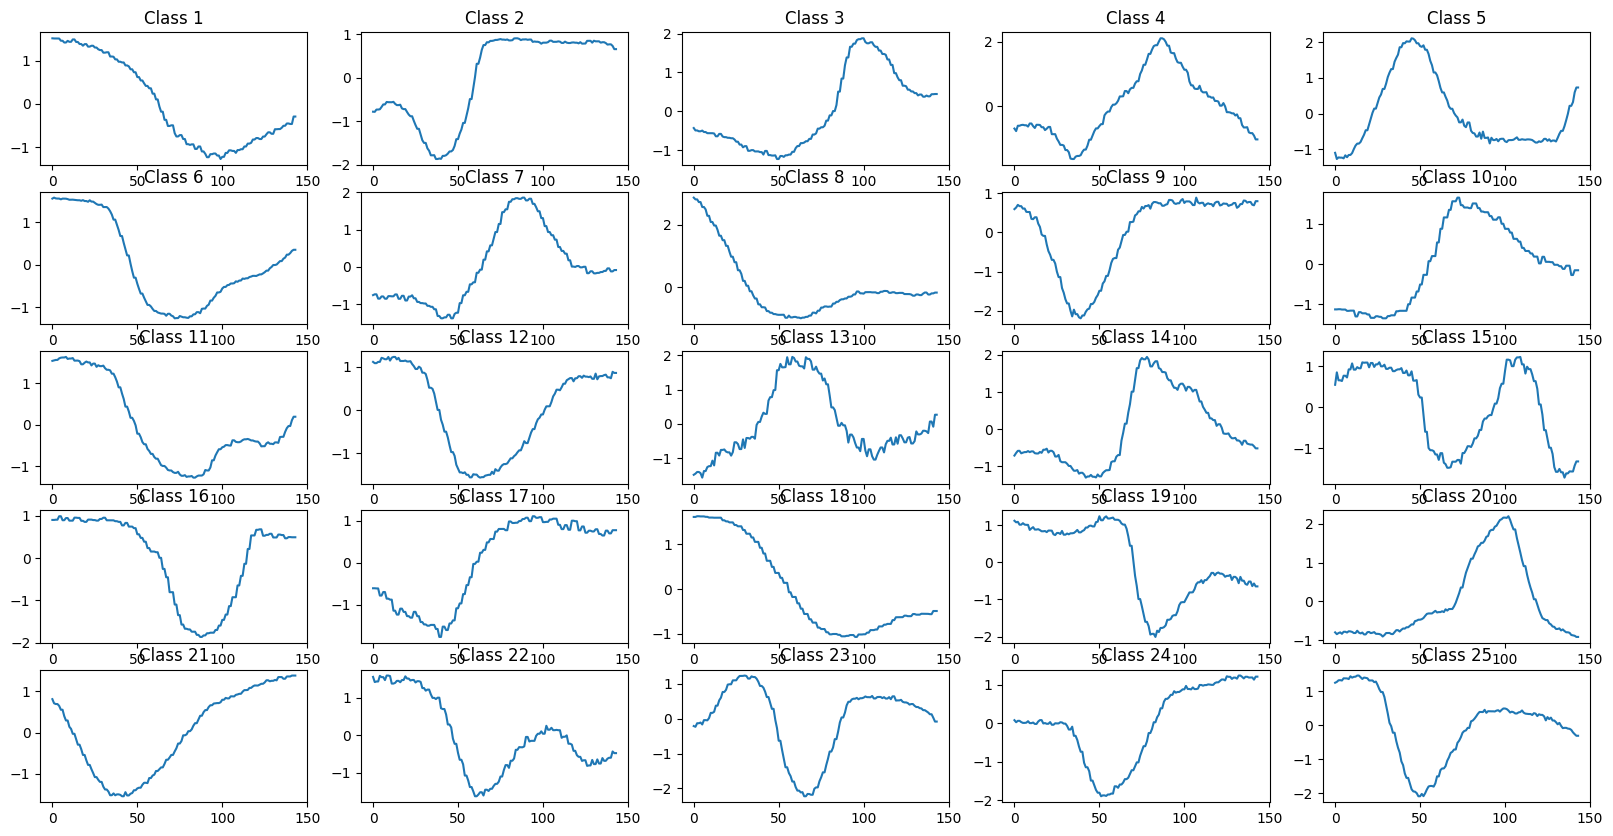

In [5]:
awr = AWRDataloader(
        dataset_path="ArticularyWordRecognition/", 
        dataset_name="AWR"
    )

signals, labels = awr.load(dimension=5, split=None, return_data=True)

# Visualize the different signals one for each class

fig,ax = plt.subplots(5,5,figsize=(20,10))
flag=[False]*25
for i in range(1,26):
    for j in range(len(labels['train'])):
        if labels['train'][j] == i and flag[i-1] ==False:
            flag[i-1]=True
            ax[(i-1)//5,(i-1)%5].plot(signals['train'][:,j])
            ax[(i-1)//5,(i-1)%5].set_title(f'Class {i}')
        

    

Let's talk about the data. 

Each signal has a length of 144 points and the train/test split is composed of 275/300 signals and on the test set the balance is respected with 12 representants for the 25 classes. What we can see on the examples is the fact that some class are close to another one : 6, 11 and 12 or 3, 4 and 14 or 22, 23 and 25.

As far as the signals are concerned, it looks like more as different pattern extracted and isolated which makes raise the question about the use of a Fourier basis to reconstruct the pattern. This is a choice for simplicity and we will see that the results are not so bad.

### 4.1 - K-SVD method for classification #### 

This is the method we want to test.

It has three hyperparameters we can tune :
- The sparsity of the reconstructed signal
- The number of atoms used by the dictionnary
- The number of neighbors used by the KNN

It takes approximately 30 seconds to run the function on our dataset.

In [20]:
def methodKSVD(signals,labels,n_atoms,sparsity,n_neighbors,max_iter=50,verbose=True):
    """
    Function that uses KSVD to learn a dictionary from the training signals and then uses KNN to classify the test signals.

    ARGS:
        - signals: dictionary containing the training and test signals
        - labels: dictionary containing the training and test labels
        - n_atoms: number of atoms in the dictionary
        - sparsity: max number of atoms used to reconstruct each signal
        - n_neighbors: number of neighbors to use for KNN
        - max_iter: max number of iterations for KSVD
        - verbose: if True, print the accuracy of the KNN classifier
    
    RETURNS:
        - accuracy: accuracy of the KNN classifier
    """
    # init KSVD
    ksvd = KSVD(n_atoms=n_atoms, sparsity=sparsity, pursuit_method=SklearnOrthogonalMatchingPursuit, verbose=False,init_dict = None)

    # fit KSVD
    sparse_signals_train = ksvd.fit(y=signals["train"], max_iter=50, return_reconstruction=True)
    

    # use KSVD to build sparse representations of test signals
    OMP = SklearnOrthogonalMatchingPursuit(sparsity=sparsity, dict=ksvd.dict, verbose=True)
    sparse_signals_test = ksvd.dict @ OMP.fit(y=signals["test"], return_coeffs=True)

    # fit KNN
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(sparse_signals_train.T, labels["train"].T)

    # predict on test set using KNN
    y_pred_test = neigh.predict(sparse_signals_test.T)

    if verbose:
        print(f"KSVD params: n_atoms={ksvd.K}, sparsity={ksvd.sparsity}, neighbors={n_neighbors}")
        print(f"Class balance in test set: {np.bincount(labels['test'].astype(int))}")   
        print(f"KNN accuracy = {np.mean(labels['test'] == y_pred_test):.3f}")


        cm = confusion_matrix(labels['test'], y_pred_test)
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        all_sample_title = 'Accuracy Score: {0}'.format(np.mean(labels['test'] == y_pred_test))
        plt.show()
        
    return np.mean(labels['test'] == y_pred_test)

Atom 8 was not used in any signal therefore it was not updated during this iteration.
KSVD params: n_atoms=20, sparsity=5, neighbors=3
Class balance in test set: [ 0 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12]
KNN accuracy = 0.730


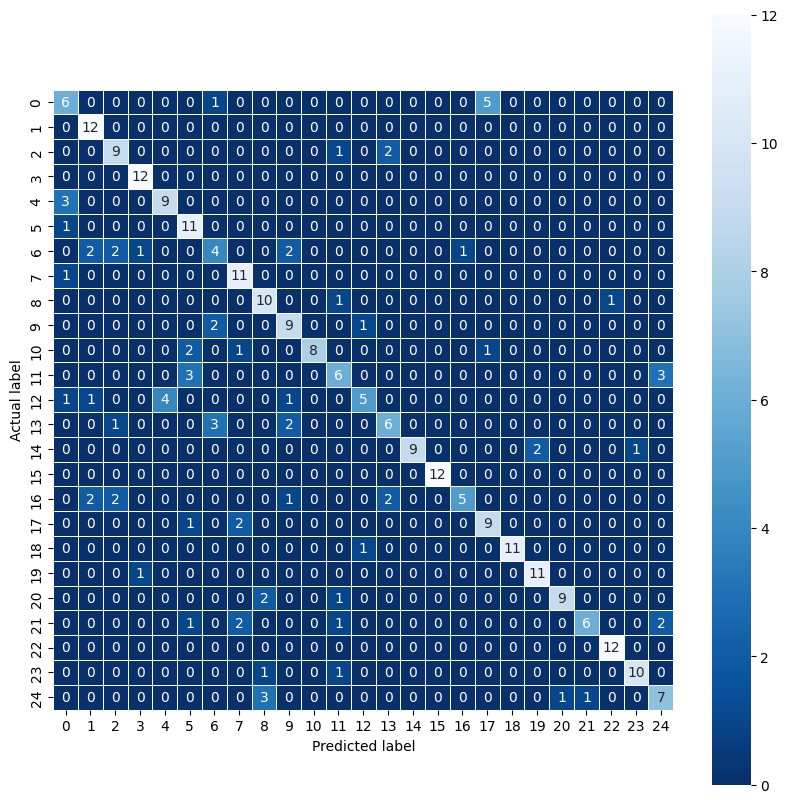

0.73

In [21]:
methodKSVD(signals,labels,n_atoms=20,sparsity=5,n_neighbors=3,max_iter=50,verbose=True)

We give some explanations on the confusion matrix later.

### 4.2 - OMP method using Fourier Basis ####

First we generate the dictionnary that will be used by the OMP method.

This method is the one with worse results but is much quicker than the other methods.

It has two hyperparameters :
- the sparsity of the reconstruction for OMP
- The number of neighbors used in the KNN

In [10]:
# Generate a matrix D with the cosines and sinus fourier fonctions for all integer frequencies 

def generate_dict(K=144,trend=True,nb_pts=1000):
    """
    Generate a matrix D with the cosines and sinus fourier fonctions for all integer frequencies
    ARGS:
        - K: number of frequencies
        - trend: if True, add the trend
        - nb_pts: number of points in the signal
    RETURNS:
        - D: matrix with the cosines and sinus fourier fonctions for all integer frequencies and trend functions
    """
    t = np.linspace(0, 1, nb_pts)
    if trend:
        D = np.zeros((len(t), 2*K+3))
    else:
        D = np.zeros((len(t), K))
    for i in range(K):
        D[:,i] = np.cos(2*np.pi*i*t)
    for i in range(1,K):
        D[:,K+i-1] = np.sin(2*np.pi*i*t)
    if trend:
        for i in range(4):
            D[:,2*K-1+i] =  t**i
    return D

generate_dict(144).shape

(1000, 291)

In [25]:
def OMPFourier(signals,labels,sparsity,n_neighbors,max_iter=50,verbose=True):
    """
    Function that uses OMP to learn a dictionary from the training signals and then uses KNN to classify the test signals.

    ARGS:
        - signals: dictionary containing the training and test signals
        - labels: dictionary containing the training and test labels
        - sparsity: max number of atoms used to reconstruct each signal
        - n_neighbors: number of neighbors to use for KNN
        - verbose: if True, print the accuracy of the KNN classifier
    
    RETURNS:
        - accuracy: accuracy of the KNN classifier
    
    """
    
    Fourier_dict = generate_dict(K=144,trend=True,nb_pts=144)

    # Apply OMP to the test set with the dictionnary found at the training K-SVD step

    omp = SklearnOrthogonalMatchingPursuit(dict=Fourier_dict, sparsity=sparsity, verbose=True)
    y_train = Fourier_dict @ omp.fit(signals['train'], precompute=False, return_coeffs=True)
    y_pred_test = Fourier_dict @  omp.fit(signals['test'], precompute=False, return_coeffs=True,force=True)

    # Apply KNN to the coefficients of the dictionary

    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(y_train.T, labels["train"].T)

    # predict on test set using KNN
    y_pred_test = neigh.predict(y_pred_test.T)

    if verbose:

        print(f"Class balance in test set: {np.bincount(labels['test'].astype(int))}")   
        print(f"KNN accuracy = {np.mean(labels['test'] == y_pred_test):.3f}")

        cm = confusion_matrix(labels['test'], y_pred_test)
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        all_sample_title = 'Accuracy Score: {0}'.format(np.mean(labels['test'] == y_pred_test))
        plt.show()

    return np.mean(labels['test'] == y_pred_test)


Class balance in test set: [ 0 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12]
KNN accuracy = 0.687


0.6866666666666666

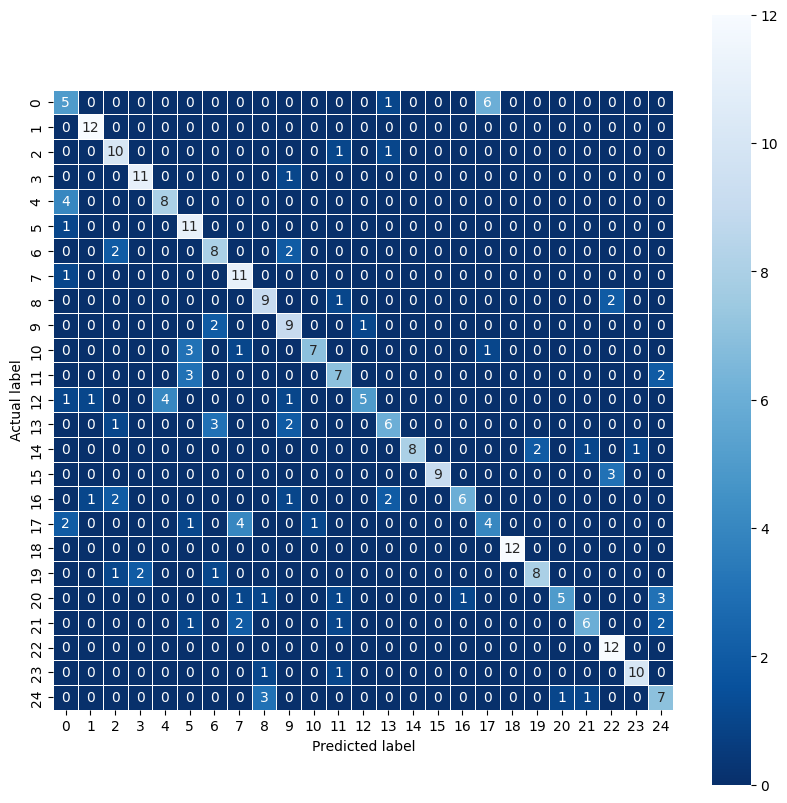

In [23]:
OMPFourier(signals,labels,sparsity=5,n_neighbors=3,max_iter=50,verbose=True)

We give some explanations on the confusion matrix later.

### 4.3 - KNN based on the DTW distance ####

This is the most natural method we thought for this task of classification.

Only one parameter to tune :
- The number of neighbors in the KNN

Achieved better results but longer to infer (approximately 4 to 5 minutes).

In [24]:
def get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray) -> float:
    """
    Return the DTW distance between signal_1 and signal_2.
    
    ARGS:
        - signal_1: first signal
        - signal_2: second signal
    
    RETURNS:
        - distance: DTW distance between signal_1 and signal_2
    """

    alignment = dtw(signal_1, signal_2, keep_internals=True)
    return alignment.distance


def dtw_knn(signals,labels,n_neighbors,verbose=True):
    # Normalize the signals

    signals['train'] = (signals['train'] - np.mean(signals['train'],axis=0))/ np.std(signals['train'],axis=0)
    signals['test'] = (signals['test'] - np.mean(signals['test'],axis=0))/ np.std(signals['test'],axis=0)

    # Apply KNN to the signals

    neigh = KNeighborsClassifier(n_neighbors=n_neighbors,metric=get_dtw_distance)
    neigh.fit(signals['train'].T, labels["train"].T)

    # predict on test set using KNN
    y_pred_test = neigh.predict(signals['test'].T)

    if verbose :
        print(f"Class balance in test set: {np.bincount(labels['test'].astype(int))}")
        print(f"KNN accuracy = {np.mean(labels['test'] == y_pred_test):.3f}")

        cm = confusion_matrix(labels['test'], y_pred_test)
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        all_sample_title = 'Accuracy Score: {0}'.format(np.mean(labels['test'] == y_pred_test))
        plt.show()

    return np.mean(labels['test'] == y_pred_test)

Class balance in test set: [ 0 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12]
KNN accuracy = 0.747


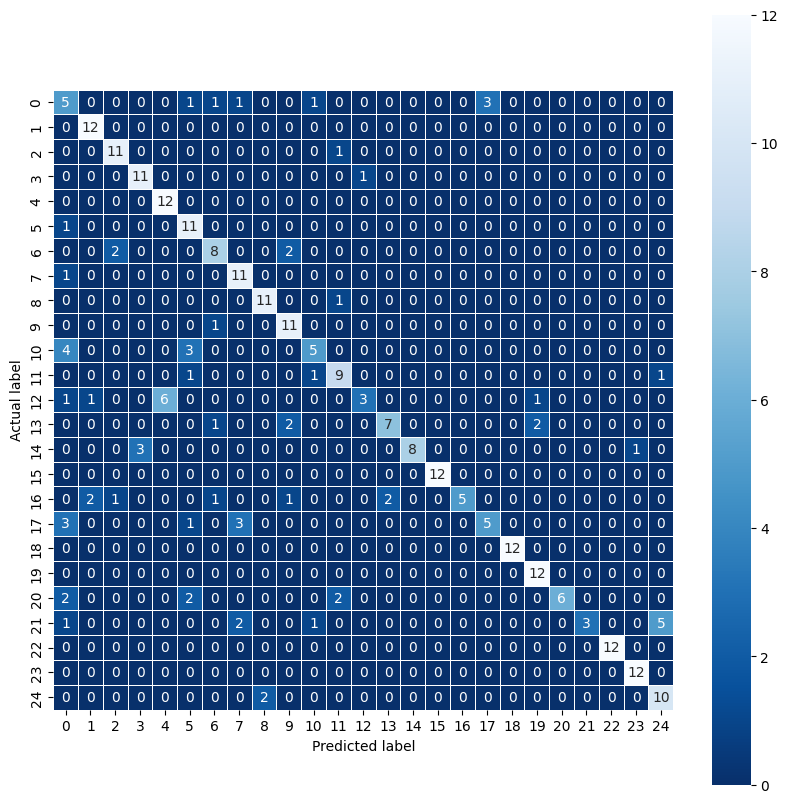

0.7466666666666667

In [26]:
dtw_knn(signals,labels,n_neighbors=3,verbose=True)

We give some explanations on the confusion matrix later.

Small Grid Search to compare the different methods (be careful it takes some time to run, we store the results in CSV)

In [27]:
n_neighbors = [1,3,5,10]
sparsity = [3,5,10,20]
n_atoms = [25,50,75,100]

In [ ]:


method = []
nn = []
spar = []
atoms = []
scores = []

for j in sparsity:
    for i in n_neighbors:
        score = OMPFourier(signals,labels,sparsity=j,n_neighbors=i,max_iter=50,verbose=True)
        method.append('OMP Fourier')
        nn.append(i)
        spar.append(j)
        atoms.append(-1)
        scores.append(score)

for i in n_neighbors:
    for j in sparsity:
        for k in n_atoms:
            score = methodKSVD(signals,labels,n_atoms=k,sparsity=j,n_neighbors=i,max_iter=50,verbose=True)
            method.append('KSVD')
            nn.append(i)
            spar.append(j)
            atoms.append(k)
            scores.append(score)

for i in n_neighbors:
    score = dtw_knn(signals,labels,n_neighbors=i,verbose=True)
    method.append('DTW')
    nn.append(i)
    spar.append(-1)
    atoms.append(-1)
    scores.append(score)

df = pd.DataFrame({'Method':method,'n_neighbors':nn,'sparsity':spar,'n_atoms':atoms,'scores':scores})

df.to_csv('./results.csv',index=False)

### 4.4 - Analysis of the results ####

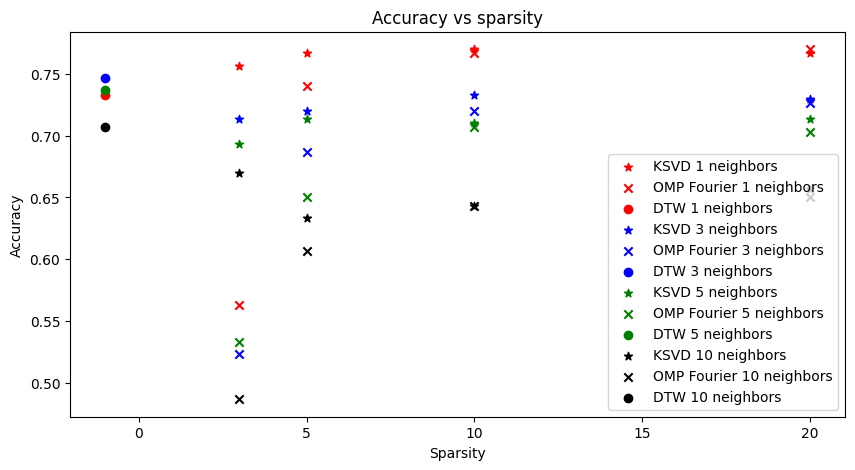

In [28]:
df = pd.read_csv('./results.csv')

color = {1:'red',3:'blue',5:'green',10:'black'}

plt.figure(figsize=(10,5))
for i in n_neighbors:
    plt.scatter(df[(df['n_neighbors']==i) & (df['Method']=='KSVD') & (df['n_atoms'] == 100)]['sparsity'],df[(df['n_neighbors']==i) & (df['Method']=='KSVD') & (df['n_atoms'] == 100)]['scores'],marker='*',label=f'KSVD {i} neighbors',color = color[i])
    plt.scatter(df[(df['n_neighbors']==i) & (df['Method']=='OMP Fourier')]['sparsity'],df[(df['n_neighbors']==i) & (df['Method']=='OMP Fourier')]['scores'],marker='x',label=f'OMP Fourier {i} neighbors',color = color[i])
    plt.scatter(df[(df['n_neighbors']==i) & (df['Method']=='DTW')]['sparsity'],df[(df['n_neighbors']==i) & (df['Method']=='DTW')]['scores'],marker='o',label=f'DTW {i} neighbors',color = color[i])

plt.legend()
plt.xlabel('Sparsity')
plt.ylabel('Accuracy')
plt.title('Accuracy vs sparsity')
plt.show()



Let's give some conclusions and insights on this graph.

How to read it :
- The marker gives the method used (o for DTW, * for K-SVD and x for OMP Fourier)
- The color gives the number oh neighbors used in the KNN
- If you want to compare the method, you should look at the different markers for one color (DTW is always on the left as it does not use the sparsity argument)

Some conclusions :
- KNN based on DTW is always better in term of accuracy except for a number of neighbor equal to one
- K-SVD is almost always better than a simple OMP with a Fourier basis
- Results are globally close
- OMP Fourier seems to be more sensitive to a shift in the parameters (for instance looking at sparsity equal to 3)

On the different confusion matrix :
- Results are quite good considering the number of classes
- Keep in mind that some classes are very close to others in this dimension so this is why it is confusing for the method (class 1, 11 and 18 for instance)
- Possible to extend what we did in multi-dimension or simply do the same thing on every dimension to have a better classification or even merge some classes for this dimension and re-apply the method on an other dimension to classify inside a super-class